In [1]:
# Install the igraph python library - see also: https://igraph.org/python/tutorial/latest/tutorial.html
# This is a library that allows internal handling of the graph with functionalities supporting nodes, edges additions/removals,
# adjacency matrix processing, plotting layouts and so on. Another even more known library is networkx: https://networkx.org/,
# with similar functionality and also possibilites of direct conversion from its graph format to PyTorch format for further
# GNN processing (although this is not always error-free).

!pip install python-igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.6 MB/s eta 0:00:00


The original paper of the GNN-LRP method is https://arxiv.org/abs/2006.03589

In [3]:
import igraph
import numpy as np


def relevance_curves_xy_computation(nodes_x_coors_list: list, nodes_y_coors_list: list):
    """
    This method performs the computation of x,y coordinate points for the relevance curves (or equivalently
    curved lines) inside the plot. The relevance curves are curves that depict the relevance of a walk,
    comprised of 3 nodes (and 2 edges connecting them) by their colour. Since several nodes can be part of
    many different walks, it was decided that curved lines, surrounding ("around") the graphs will show the
    relevances of each walk in the graph (which is depicted in black) - so that there is no overlap.
    This is a plot helper method and not a relevance computation method.

    :param nodes_x_coors_array: List of the 3 x-coordinates of the nodes in the walk
    :param nodes_y_coors_array: List of the 3 y-coordinates of the nodes in the walk
    :return:
    """

    relevance_line_curve_x_coors_list = np.array(nodes_x_coors_list)
    relevance_line_curve_y_coors_list = np.array(nodes_y_coors_list)

    if relevance_line_curve_x_coors_list[0] == relevance_line_curve_x_coors_list[1] == relevance_line_curve_x_coors_list[2] and \
            relevance_line_curve_y_coors_list[0] == relevance_line_curve_y_coors_list[1] == relevance_line_curve_y_coors_list[2]:
        relevance_line_curve_x_coors_list = relevance_line_curve_x_coors_list[0] + 0.1 * np.cos(np.linspace(0, 2 * np.pi, 50))
        relevance_line_curve_y_coors_list = relevance_line_curve_y_coors_list[0] + 0.1 * np.sin(np.linspace(0, 2 * np.pi, 50))
    else:
        relevance_line_curve_x_coors_list = 0.75 * relevance_line_curve_x_coors_list + 0.25 * relevance_line_curve_x_coors_list.mean()
        relevance_line_curve_y_coors_list = 0.75 * relevance_line_curve_y_coors_list + 0.25 * relevance_line_curve_y_coors_list.mean()

        relevance_line_curve_x_coors_list = np.concatenate([
            np.linspace(relevance_line_curve_x_coors_list[0], relevance_line_curve_x_coors_list[0], 41),
            np.linspace(relevance_line_curve_x_coors_list[0], relevance_line_curve_x_coors_list[1], 20),
            np.linspace(relevance_line_curve_x_coors_list[1], relevance_line_curve_x_coors_list[2], 20),
            np.linspace(relevance_line_curve_x_coors_list[2], relevance_line_curve_x_coors_list[2], 41), ])
        relevance_line_curve_y_coors_list = np.concatenate([
            np.linspace(relevance_line_curve_y_coors_list[0], relevance_line_curve_y_coors_list[0], 41),
            np.linspace(relevance_line_curve_y_coors_list[0], relevance_line_curve_y_coors_list[1], 20),
            np.linspace(relevance_line_curve_y_coors_list[1], relevance_line_curve_y_coors_list[2], 20),
            np.linspace(relevance_line_curve_y_coors_list[2], relevance_line_curve_y_coors_list[2], 41)])

        filt = np.exp(-np.linspace(-2, 2, 41) ** 2)
        filt = filt / filt.sum()

        relevance_line_curve_x_coors_list = np.convolve(relevance_line_curve_x_coors_list, filt, mode='valid')
        relevance_line_curve_y_coors_list = np.convolve(relevance_line_curve_y_coors_list, filt, mode='valid')


    return relevance_line_curve_x_coors_list, relevance_line_curve_y_coors_list

def compute_walks(adj_matrix: np.ndarray):
    """
    Compute all walks of length 3

    :param adj_matrix: Adjacency matrix of graph
    :return:
    """

    w = []

    for v1 in np.arange(len(adj_matrix)):
        for v2 in np.where(adj_matrix[v1])[0]:
            for v3 in np.where(adj_matrix[v2])[0]:

                w += [(v1, v2, v3)]

    return w


def set_graph_layout(adj_matrix: np.ndarray, seed):
    """
    Creates a graph and sets the graph layout according to a set of edges and nodes in adj_matrix

    :param adj_matrix: Adjacency matrix
    :param seed: Random seed of graph
    :return:
    """

    graph = igraph.Graph()
    graph.add_vertices(len(adj_matrix))
    graph.add_edges(zip(*np.where(adj_matrix == 1)))

    return np.array(list(graph.layout_kamada_kawai()))

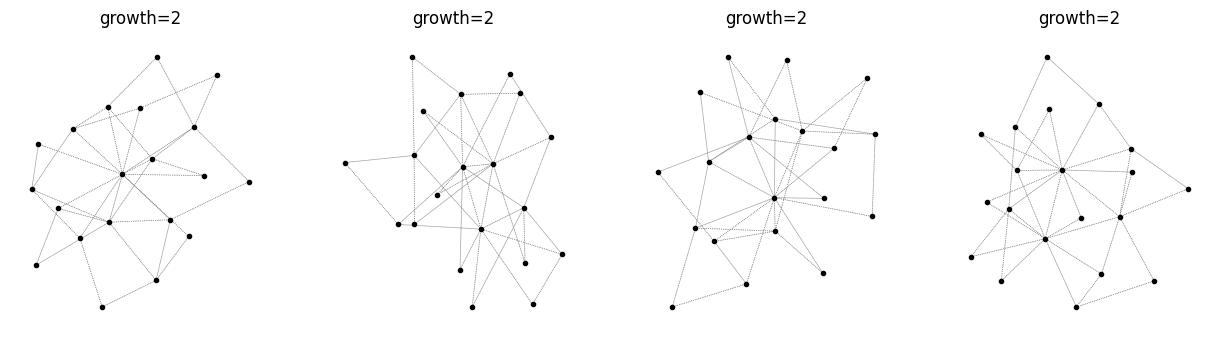

Training model:
   iter | loss
   -----------
       0 0.500
    1000 0.471
    2000 0.240
    3000 0.103
    4000 0.048
    5000 0.024
    6000 0.013
    7000 0.009
    8000 0.008
    9000 0.009
   10000 0.007
   11000 0.006
   12000 0.006
   13000 0.005
   14000 0.004
   15000 0.005
   16000 0.005
   17000 0.004
   18000 0.004
   19000 0.004
   20000 0.004
For 200 test sample graphs, the model predicts the growth parameter with an accuracy of 100.0 %


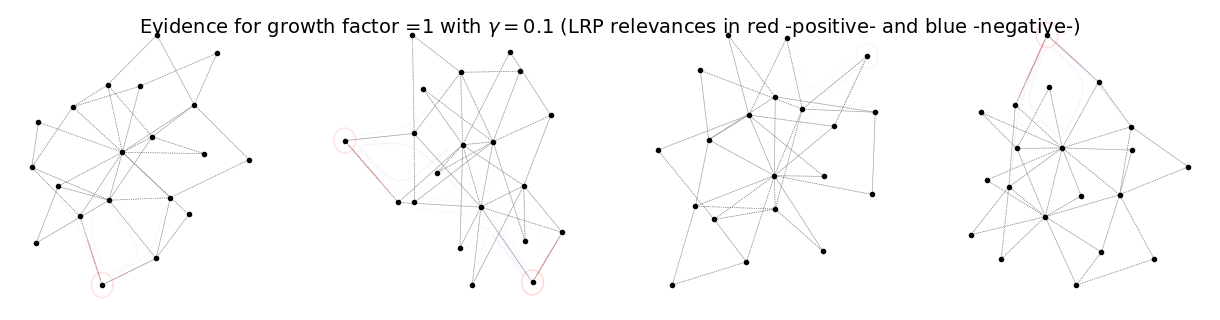

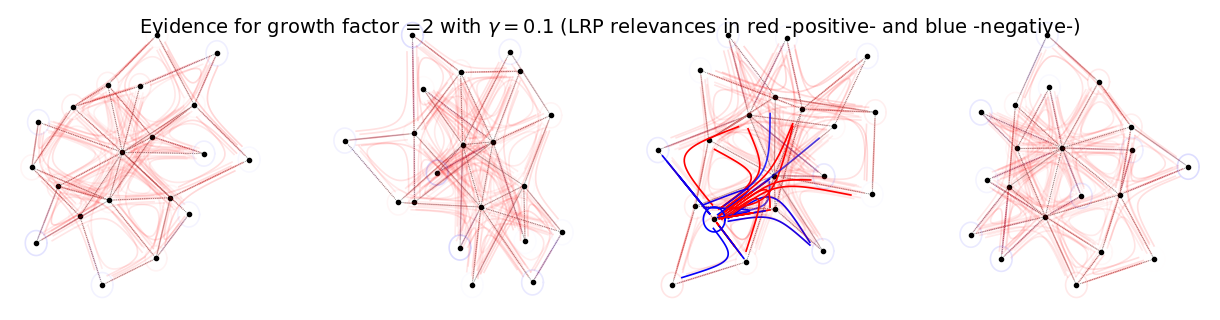

In [4]:
import random
import sys

import igraph
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch


########################################################################################################################
# [A.] Create example graphs and plots thereof =========================================================================
########################################################################################################################
def create_scale_free_graph(nodes_nr: int, input_seed: int = 0, embed: bool = False, growth=None):
    """
    # Imlementation of the Barabasi-Albert model for the creation of scale-free graphs.
    A scale-free graph has a degree distribution that follows a power law - asymptotically.
    The fraction P(k) of nodes in the network having k connections to other nodes goes for large values of k:
    P(k) ∼ pow(k, −γ)
    In this method the γ (gamma) is sampled uniformly being either 1, 2, or 3.

    :param nodes_nr: Number of graph nodes
    :param input_seed: Seed for the random generation
    :param embed: Parameter that will be used for visualization
    :param growth: Growth parameter of the Barabasi-Albert (BA) method. The scale-free graph increases over time.
    At each timestep a new node with "growth" number of links that connect the new node to "growth" number of nodes
    already in the network is added.
    :return:
    """

    # [1.] Define number of nodes and the adjacency matrix -------------------------------------------------------------
    adj_matrix = np.zeros([nodes_nr, nodes_nr])     # Adjacency Matrix
    adj_matrix[1, 0] = 1
    adj_matrix[0, 1] = 1

    # The generated graph that increases over time. At each timestep a new node with "growth" number of links that -----
    # connect the new node to "growth" number of nodes already in the network is added ---------------------------------
    random = np.random.mtrand.RandomState(input_seed)
    growth = growth if growth is not None else random.randint(1, 3)
    N0 = 2

    # [2.] Create the edges according to the growth parameter ----------------------------------------------------------
    #      The number of nodes in the graph is specified here. What is not specified is the edges.
    #      The code implementation defines the process of creating the scale-free graph from scratch.
    #      Assuming that we are in a step of this process, and we already have a graph of some sort,
    #      we can think of incrementing this graph by inserting a new node, that will be connected to
    #      some other in the already existing graph. The decision of which node will the new one "dock to"
    #      (have an edge with) is specified by the growth factor. It defines with what probability the
    #      new node will be connected to the nodes the graph already has.
    for i in range(N0, nodes_nr):
        if growth == 1 : tt = 1     # Barabasi-Albert with growth 1
        elif growth == 2 : tt = 2   # Barabasi-Albert with growth 2
        else:
            tt = 1 + 1*((growth-1) > random.uniform(0, 1))

        p = adj_matrix.sum(axis=0)/adj_matrix.sum()

        for j in random.choice(nodes_nr, tt, p=p, replace=False):
            adj_matrix[i, j] = 1
            adj_matrix[j, i] = 1

    r = random.permutation(len(adj_matrix))
    adj_matrix = adj_matrix[r][:, r]*1.0

    # [3.] Add Self-Connections in the Adjacency matrix ----------------------------------------------------------------
    adj_matrix = adj_matrix + np.identity(len(adj_matrix))

    # [4.] Compute Laplacian of the graph ------------------------------------------------------------------------------
    D = adj_matrix.sum(axis=1)
    laplacian_matrix = torch.FloatTensor(adj_matrix/(np.outer(D, D)**.5+1e-9))

    # [5.] Compute the graph information data structure (dictionary) ---------------------------------------------------
    #      The dataset is comprised by pairs of (graph_of_growth_factor, growth_factor)
    #      the second one being the target, as one sees in the returned data structure
    return {
        'adjacency': torch.FloatTensor(adj_matrix),
        'laplacian': laplacian_matrix,
        'target': growth,
        'layout': set_graph_layout(adj_matrix, input_seed) if embed else None,
        'walks': compute_walks(adj_matrix)
    }


def visualize_graph(graph_data_structure: dict, ax):
    """
    Function to visualise a graph

    :param graph_data_structure: Graph information data structure (dictionary)
    :param ax: Axis of plot
    :return:
    """

    # [1.] Arrange graph layout for plot -------------------------------------------------------------------------------
    r = graph_data_structure['layout']
    r = r - r.min(axis=0)
    r = r / r.max(axis=0) * 2 - 1

    # [2.] Plot the edges ----------------------------------------------------------------------------------------------
    nodes_nr = len(graph_data_structure['adjacency'])
    for i in np.arange(nodes_nr):
        for j in np.arange(nodes_nr):
            if graph_data_structure['adjacency'][i, j] > 0 and i != j: plt.plot([r[i, 0], r[j, 0]], [r[i, 1], r[j, 1]],
                                                                                color='gray',
                                                                                lw=0.5,
                                                                                ls='dotted')

    # [3.] Plot the nodes ----------------------------------------------------------------------------------------------
    ax.plot(r[:, 0], r[:, 1], 'o', color='black', ms=3)


# Plot some example graphs ---------------------------------------------------------------------------------------------
sample_ids = [1, 3, 4, 5]
nodes_nr = 20

plt.figure(figsize=(3 * len(sample_ids), 3))
for ids, seed in enumerate(sample_ids):

    ax = plt.subplot(1, len(sample_ids), ids + 1)
    example_graph = create_scale_free_graph(nodes_nr, input_seed=seed, embed=True, growth=2)


    visualize_graph(example_graph, ax=ax)
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

    plt.axis('off')
    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    ax.set_title(f"growth={example_graph['target']}")

plt.show()
plt.close()


########################################################################################################################
# [B.] Create GraphNet GNN ::: Define architecture, forward and lrp methods ============================================
########################################################################################################################
class GraphNet:
    """
    Graph Net - The Graph Neural Network (GNN)

    The adjacency matrix is not enough in general. Graph nodes do have features
    (think of values representing size, color and so on) and edges also having
    corresponding ones (distance, weight...). So only in this case, this very
    simple graph where in principle only connectivity is used for the
    classification, the adjacency matrix is enough.

    """

    def __init__(self, input_layer_size: int, hidden_layer_size: int, output_layer_size: int):
        """
        GNN init architecture

        :param input_layer_size: Input layer size
        :param hidden_layer_size: Hidden layer size
        :param output_layer_size: Output layer size
        """

        # [1.] Architecture of the GNN ---------------------------------------------------------------------------------
        #      Weights/parameters of the GNN ---------------------------------------------------------------------------
        #      U the weights/parameters of the input layer, V the weights parameters of the last layer -----------------
        self.U = torch.nn.Parameter(torch.FloatTensor(np.random.normal(0, input_layer_size ** -.5,
                                                                       [input_layer_size, hidden_layer_size])))
        self.W1 = torch.nn.Parameter(torch.FloatTensor(np.random.normal(0, hidden_layer_size ** -.5,
                                                                        [hidden_layer_size, hidden_layer_size])))
        self.W2 = torch.nn.Parameter(torch.FloatTensor(np.random.normal(0, hidden_layer_size ** -.5,
                                                                        [hidden_layer_size, hidden_layer_size])))
        self.V = torch.nn.Parameter(torch.FloatTensor(np.random.normal(0, hidden_layer_size ** -.5,
                                                                       [hidden_layer_size, output_layer_size])))

        # [2.] Weights/parameters of the GNN ---------------------------------------------------------------------------
        self.params = [self.U, self.W1, self.W2, self.V]

    def forward_pass(self, adj_matrix: torch.Tensor):
        """
        Forward pass of the GNN

        :param adj_matrix: Adjacency matrix of the GNN
        :return:
        """

        H = torch.eye(len(adj_matrix))
        H = H.matmul(self.U).clamp(min=0)
        H = (adj_matrix.transpose(1, 0).matmul(H.matmul(self.W1))).clamp(min=0)
        H = (adj_matrix.transpose(1, 0).matmul(H.matmul(self.W2))).clamp(min=0)
        H = H.matmul(self.V).clamp(min=0)

        return H.mean(dim=0)

    def lrp_computation(self, adj_matrix: torch.Tensor, gamma: float, target: int, indexes: tuple):
        """
        Compute the LRP relevance, as presented in the original paper: https://arxiv.org/abs/2006.03589

        :param adj_matrix: Adjacency matrix of the graph
        :param gamma: LRP gamma hyperparameter
        :param target: Target class
        :param indexes: Indexes of nodes in the graph
        """

        # [1.] Create a column array which contains only one non-zero element ------------------------------------------
        #      in the position of the node index contained in the walk -------------------------------------------------
        if indexes is not None:

            j, k = indexes
            M_j = torch.FloatTensor(np.eye(len(adj_matrix))[j][:, np.newaxis])
            M_k = torch.FloatTensor(np.eye(len(adj_matrix))[k][:, np.newaxis])

        # [2.] Weights of the GNN (U, W1, W2, V) plus a weighted version of their positive part ------------------------
        #      The ReLu of equation 9 in page 5, Table 1 of the original paper is implemented by the clamp() method ----
        W1p = self.W1 + gamma * self.W1.clamp(min=0)
        W2p = self.W2 + gamma * self.W2.clamp(min=0)
        Vp = self.V + gamma * self.V.clamp(min=0)

        # [3.] Define a tensor that will contain the results of the LRP ------------------------------------------------
        #      Enable the automatic differentiation mechanism for this tensor ------------------------------------------
        X = torch.eye(len(adj_matrix))
        X.requires_grad_(True)

        # [4.] Multiply the identity matrix (starting values of the LRP results tensor) --------------------------------
        #      with the weights of the input layer ---------------------------------------------------------------------
        H = X.matmul(self.U).clamp(min=0)                           # H_0

        ################################################################################################################
        # [5.] Perform the computation of equations for the 1st layer as described the original paper ------------------
        # [5.1.] (Lambda * H_0) * W_1 = Z_1 * W_1                   # Page 5 of original paper -------------------------
        # This is a component of the right part of the equation computing Q_t  -----------------------------------------
        # P = (Lambda * H_0) * W_1 = Z_1 * W_1 -------------------------------------------------------------------------
        # This variable is useful for the computation of Qt ------------------------------------------------------------
        P = adj_matrix.transpose(1, 0).matmul(H.matmul(self.W1))

        # [5.2.] Pt = (Lambda * H_0) * W_1^ = Z_1 * W_1^ = P_1           # Page 5 of original paper --------------------
        Pt = adj_matrix.transpose(1, 0).matmul(H.matmul(W1p))

        # [5.3.] Q_1 = P_1 :::element_wise_mult::: [RelU(Z_1 * W_1) / P_t]cst. -----------------------------------------
        Qt = (Pt * (P / (Pt + 1e-6)).data).clamp(min=0)

        # [5.4.] H_1 = Q_1 :::element_wise_mult::: M_j + [Q_t]cst. :::element_wise_mult::: (1 - M_j) -------------------
        #        Mutliplication with the column array which contains only one non-zero element in the position of the --
        #        node index contained in the walk, as defined in step [1.] of this method ------------------------------
        if indexes is not None: H = Qt * M_j + (1 - M_j) * (Qt.data)

        ################################################################################################################
        # [6.] Perform the computation of equations for the 2nd layer as described the original paper ------------------
        #      Corresponds to the equations for the 1st layer ----------------------------------------------------------
        P = adj_matrix.transpose(1, 0).matmul(H.matmul(self.W2))
        Pt = adj_matrix.transpose(1, 0).matmul(H.matmul(W2p))
        Qt = (Pt * (P / (Pt + 1e-6)).data).clamp(min=0)

        if indexes is not None: H = Qt * M_k + (1 - M_k) * (Qt.data)

        ################################################################################################################
        # [7.] Perform the computation of equations for the 3d layer as described the original paper -------------------
        #      Corresponds to the equations for the 1st and 2nd layer --------------------------------------------------
        P = H.matmul(self.V)
        Pt = H.matmul(Vp)
        Qt = (Pt * (P / (Pt + 1e-6)).data).clamp(min=0)

        ################################################################################################################
        # [8.] Compute the mean w.r.t. the target class and apply the automatic differentiation ------------------------
        Y = Qt.mean(dim=0)[target]
        Y.backward()

        return X.data * X.grad


########################################################################################################################
# [C.] Train GNN model =================================================================================================
########################################################################################################################
def train_gnn_model():
    """
    Train the GNN model

    :return:
    """

    # [1.] Train the model with size of input layer: 10, size of hidden layer: 64, size of output layer: 2 -------------
    hidden_layer_size = 128  # Passer de 64 à 128 par exemple
    output_layer_size = 3    # Si vous souhaitez ajouter une classe supplémentaire
    gnn_model = GraphNet(nodes_nr, hidden_layer_size, output_layer_size)

    optimizer = torch.optim.SGD(gnn_model.params, lr=0.001, momentum=0.99)  # Use SGD optimizer ------------------------
    loss_avg = 0.5    # Running average of the MSE ---------------------------------------------------------------------

    print('Training model:')
    print('   iter | loss')
    print('   -----------')

    train_iterations = 20001

    for iteration in range(0, train_iterations):
        optimizer.zero_grad()

        # [2.] Create a new scale-free graph ---------------------------------------------------------------------------
        input_graph = create_scale_free_graph(nodes_nr, input_seed=iteration, embed=False)

        # [3.] Forward the input graph's laplacian to the model --------------------------------------------------------
        y = gnn_model.forward_pass(input_graph['laplacian'])

        # [4.] Compute the error between the true value and the predicted one ------------------------------------------
        loss = (y[0]-(input_graph['target'] == 1)*1.0)**2 + (y[1]-(input_graph['target'] == 2)*1.0)**2

        #      This is a running average of the MSE --------------------------------------------------------------------
        loss_avg = 0.999*loss_avg + 0.001*loss.data.numpy()

        # [5.] Backpropagate a weighted sum of the average error and the currently computed error ----------------------
        loss.backward()
        optimizer.step()

        # [6.] Print the average error at each iteration ---------------------------------------------------------------
        if iteration % 1000 == 0:
            print('% 8d %.3f' % (iteration, loss_avg))

    return gnn_model


model = train_gnn_model()

########################################################################################################################
# [D.] Test GNN model ==================================================================================================
########################################################################################################################
test_size = 200
num_false = 0

# Create new graphs for the test set -----------------------------------------------------------------------------------
for it in range(20001, 20001 + test_size):

    test_graph = create_scale_free_graph(nodes_nr, input_seed=it, embed=False)
    y = model.forward_pass(test_graph['laplacian'])
    prediction = int(y.data.argmax()) + 1

    if prediction != test_graph['target'] : num_false += 1

print('For {} test sample graphs, the model predicts the growth parameter with an accuracy of {} %'.
      format(test_size, 100 * (test_size - num_false)/test_size))


########################################################################################################################
# [E.] Explain and plot relevances =====================================================================================
########################################################################################################################
def explain_graph_LRP(input_graph: dict, nn: GraphNet, target: int, gamma=None, ax=None):
    """
    Explain a graph prediction through GNN-LRP

    :param input_graph: Dictionary of input graph information
    :param nn: GNN
    :param target: target class
    :param gamma: LRP gamma hyperparameter
    :param ax: Plot axis
    :return:
    """

    # [1.] Plot the underlying graph in black --------------------------------------------------------------------------
    r = input_graph['layout']
    r = r - r.min(axis=0)
    r = r / r.max(axis=0) * 2 - 1

    N = len(input_graph['adjacency'])
    for i in np.arange(N):
        for j in np.arange(N):
            if input_graph['adjacency'][i, j] > 0 and i != j: plt.plot([r[i, 0], r[j, 0]], [r[i, 1], r[j, 1]],
                                                                       color='gray',
                                                                       lw=0.5,
                                                                       ls='dotted')
    ax.plot(r[:, 0], r[:, 1], 'o', color='black', ms=3)

    # [2.] For all walks of length 3 compute and plot the relevances ---------------------------------------------------
    for (i, j, k) in input_graph['walks']:

        R = nn.lrp_computation(input_graph['laplacian'], gamma, target, (j, k))[i].sum()
        tx, ty = relevance_curves_xy_computation([r[i, 0], r[j, 0], r[k, 0]], [r[i, 1], r[j, 1], r[k, 1]])

        # Positive (red) or negative (blue) relevance defines the explanation colorbar ----------------------------------------------------------
        # Depending on the intensity of the relevance, define the transparency parameter alpha -------------------------
        if R > 0.0:
            alpha = np.clip(20 * R.data.numpy(), 0, 1)
            ax.plot(tx, ty, alpha=alpha, color='red', lw=1.2)

        if R < -0.0:
            alpha = np.clip(-20 * R.data.numpy(), 0, 1)
            ax.plot(tx, ty, alpha=alpha, color='blue', lw=1.2)


########################################################################################################################
# Generate new graph - new test sample ---------------------------------------------------------------------------------
# Pass this example through the GNN and compute the relevance of the paths of this graph -------------------------------
#
# Red denotes positive relevance/contribution to the predicted class, even if it's a wrong prediction ------------------
# Blue denotes negative relevance/contribution to the predicted class, even it it's a wrong prediction -----------------
########################################################################################################################
gamma = 0.1

for target in [0, 1]:

    plt.figure(figsize=(3 * len(sample_ids), 3))

    for ids, seed in enumerate(sample_ids):
        ax = plt.subplot(1, len(sample_ids), ids + 1)
        example_graph = create_scale_free_graph(nodes_nr, input_seed=seed, embed=True, growth=2)


        # Explain with LRP ---------------------------------------------------------------------------------------------
        explain_graph_LRP(example_graph, model, target, gamma=gamma, ax=ax)
        plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

        plt.axis('off')
        plt.xlim(-1.2, 1.2)
        plt.ylim(-1.2, 1.2)

    plt.suptitle(f"Evidence for growth factor ={target + 1} with $\gamma={gamma}$ (LRP relevances in red -positive- and blue -negative-)", size=14)
    plt.show()
    plt.close()
